In [193]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy.lib.function_base import quantile
from pandas import value_counts
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json

In [194]:
sns.set_style("whitegrid") 
sns.set_context("paper")

# Packet Processing Time

In [195]:
raw_df = pd.read_csv("../log/stat.csv")
raw_df['time'] = raw_df['time'] - raw_df['time'].min()
raw_df.head()

,time,level,file,line,msg,pkt_count,tcp_pkt_count_tot,udp_pkt_count_tot,icmp_pkt_count_tot,unsupported_pkt_count,...,install_buf_size,replied_flow_count_tot,replied_flow_count_tcp,replied_flow_count_udp,replied_flow_count_icmp,expired_pkt_count_tot,expired_pkt_count_tcp,expired_pkt_count_udp,expired_pkt_count_icmp,active_host_tbl_entry_count
0,0.000000,STATS,src/tsdn.c,490,pkt_processing_time,1000,43.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.006233,STATS,src/tsdn.c,490,pkt_processing_time,2000,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.012517,STATS,src/tsdn.c,490,pkt_processing_time,3000,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.018487,STATS,src/tsdn.c,490,pkt_processing_time,4000,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.024719,STATS,src/tsdn.c,490,pkt_processing_time,5000,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
stats_df = raw_df[raw_df['msg'] == 'stats']
stats_df.reset_index(inplace=True)

pkt_process_time_df = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_process_time_df.columns = ['time', 'sample_at', 'pkt_process_time']
pkt_process_time_df.reset_index(inplace=True)
print(pkt_process_time_df.head())

timeout_df = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
timeout_df.columns = ['time', 'timeout']
timeout_df.reset_index(inplace=True)
print(timeout_df.head())

   index      time  sample_at  pkt_process_time
0      0  0.000000       1000              43.0
1      1  0.006233       2000              19.0
2      2  0.012517       3000              26.0
3      3  0.018487       4000              20.0
4      4  0.024719       5000              10.0
   index      time  timeout
0     16  0.094277    37969
1     27  0.157647    36807
2     37  0.222533    26675
3     50  0.314480    36696
4     61  0.395600    39432


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

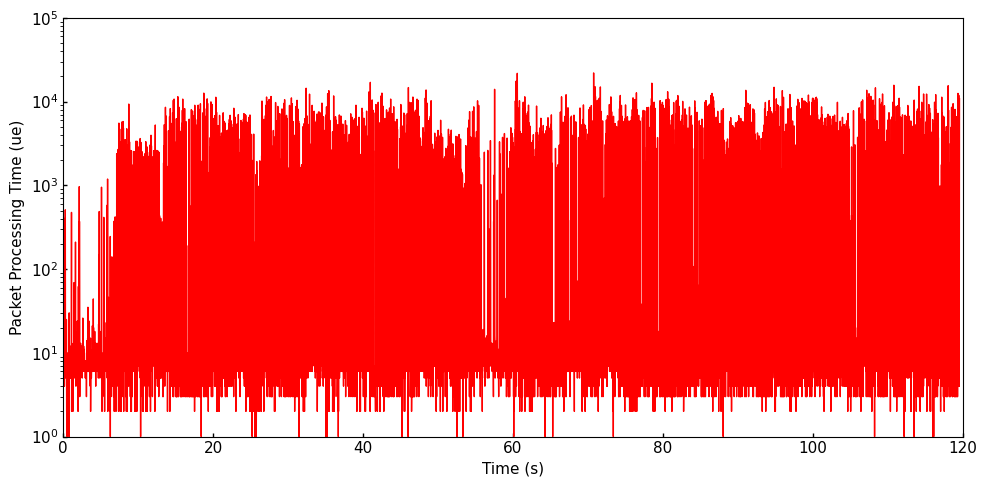

In [197]:
fastplot.plot((pkt_process_time_df['time'], pkt_process_time_df['pkt_process_time']), None, mode='line',
              yscale='log',
              figsize=(10, 5), xlabel='Time (s)', ylabel='Packet Processing Time (ue)')

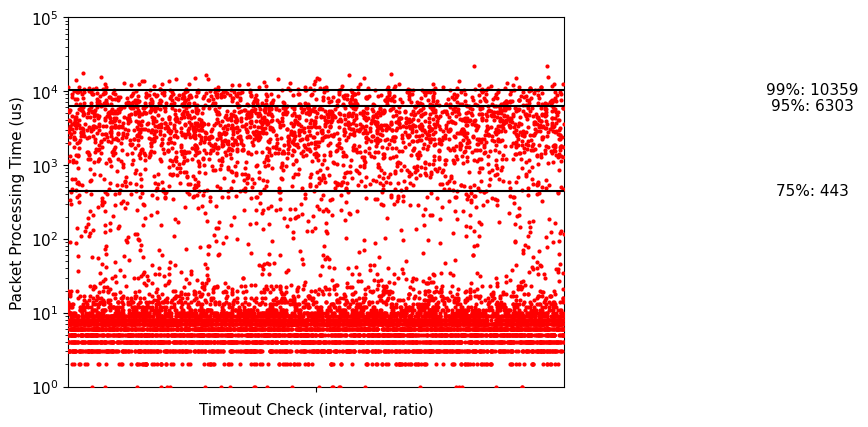

In [198]:
sns.stripplot(y='pkt_process_time', 
              size=3, legend=False,
              data=pkt_process_time_df, jitter=0.2)
plt.ylabel('Packet Processing Time (us)')
plt.xlabel('Timeout Check (interval, ratio)')
plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = pkt_process_time_df['pkt_process_time'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))

# adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)


# Timeout Bias (real buffered time (avg) - expected buffered time)

([Text(0.16285282258064515, 34989.468614718615, '75%: 35125'),
  Text(0.16275201612903223, 38576.183766233764, '95%: 39185'),
  Text(0.1626008064516129, 40272.573463203466, '99%: 39934')],
 [])

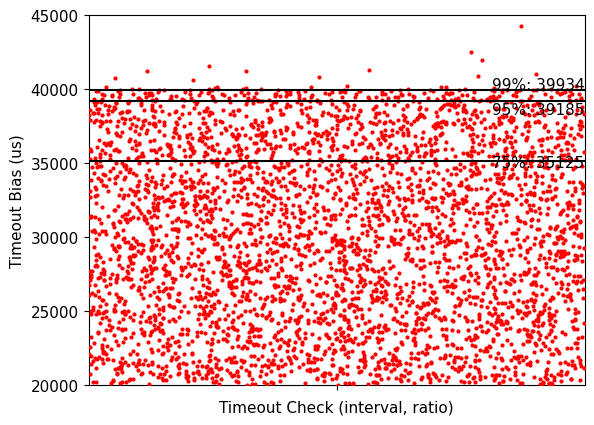

In [199]:
sns.stripplot(y='timeout', 
              size=3, legend=False,
              data=timeout_df, jitter=0.2)
plt.ylabel('Timeout Bias (us)')
plt.xlabel('Timeout Check (interval, ratio)')
# plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = timeout_df['timeout'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))
    
adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

# Data Structure Usage

In [200]:
from cycler import cycler

mcolor_lists = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green','tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'b', 'g', 'r', 'c', 'm', 'y', 'k',
                'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'rosybrown', 'tomato', 'yellowgreen', 'lightseagreen', 'navy', 'deeppink',
                'darkslategray', 'darkolivegreen', 'darkcyan', 'darkviolet', 'mediumslateblue', 'darkorange', 'gold', 'peru', 'darkkhaki']
CYCLER_LINES=(cycler('color', mcolor_lists[:30]) +
              cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--', '-.', ':', (0, (10, 6)), (0, (6, 10)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)), (0, (3, 1, 1, 1)),
                                   '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 10)), (0,
                                                                                           (10, 6)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)),
                                   '-', '--', '-.', ':']))

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

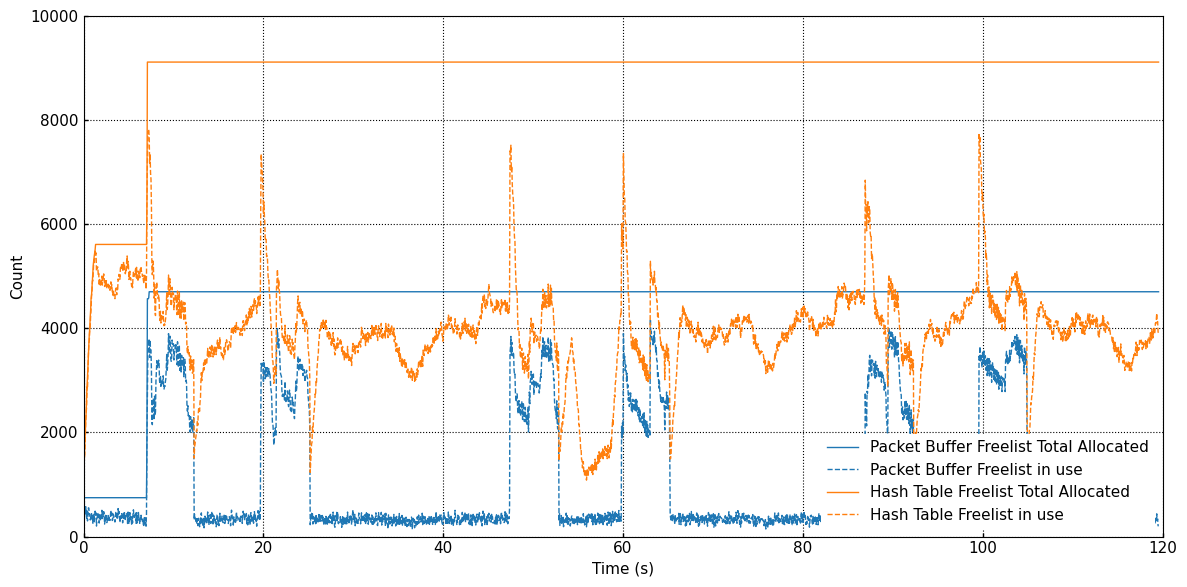

In [201]:
# buffered packet count

fastplot.plot([('Packet Buffer Freelist Total Allocated', (stats_df['time'], stats_df['pkt_list_count_tot'])),
              ('Packet Buffer Freelist in use', (stats_df['time'], stats_df['pkt_list_count_use'])),
               ('Hash Table Freelist Total Allocated', (stats_df['time'], stats_df['flow_hash_list_count_tot'])),
              ('Hash Table Freelist in use', (stats_df['time'], stats_df['flow_hash_list_count_use']))
              ],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              # yscale='log', ylim=(10**3, 10**4),
              cycler=CYCLER_LINES,
              xlabel='Time (s)', 
              ylabel='Count')


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

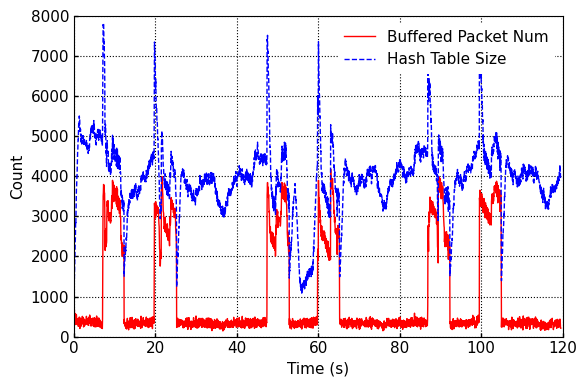

In [202]:
# buffered packet count

fastplot.plot([('Buffered Packet Num', (stats_df['time'], stats_df['pkt_buf_count'])),
              ('Hash Table Size', (stats_df['time'], stats_df['flow_hash_count']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(6, 4), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

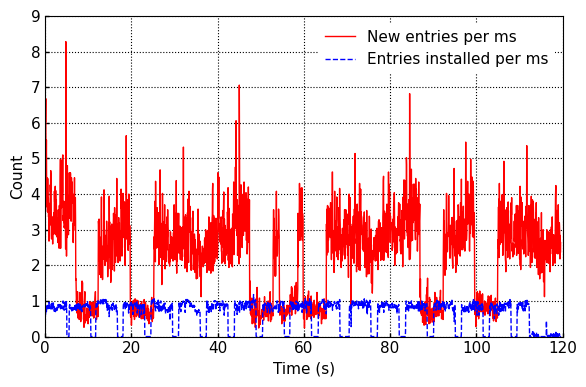

In [203]:
new_entry_cnt_ms = stats_df['replied_flow_count_tot'].diff()[1:].apply(lambda x: x/50)
instal_entry_cnt_ms = stats_df['installed_entry_count_tot'].diff()[1:].apply(lambda x: x/50)

fastplot.plot([('New entries per ms', (stats_df['time'][1:], new_entry_cnt_ms)),
                ('Entries installed per ms', (stats_df['time'][1:], instal_entry_cnt_ms))],
                None,
                mode='line_multi',
                legend=True, legend_loc='best',
                figsize=(6, 4), grid=True,
                xlabel='Time (s)', 
                ylabel='Count')

# Data Plane Resource Usage

## Table Entry Count

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

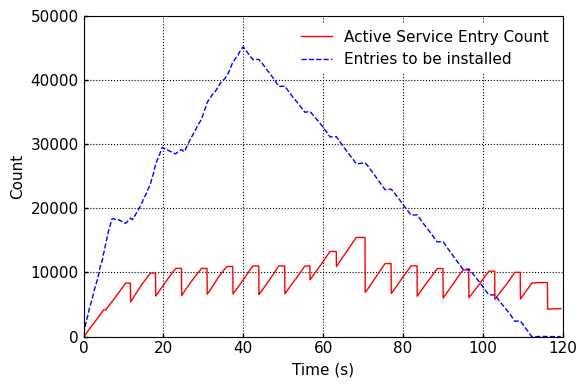

In [205]:

fastplot.plot([('Active Service Entry Count', (stats_df['time'], stats_df['active_host_tbl_entry_count'])),
               ('Entries to be installed', (stats_df['time'], stats_df['install_buf_size']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(6, 4), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')

# Network Speed Statistic

In [208]:
recv_speed_df = []

with open('../log/recv_speed_log.json', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'jsonversion' not in line and 'maxratestring' not in line:
            line = json.loads(line)
            recv_speed_df.append({'time': line['seconds'], 'rx_speed': line['rx']['ratestring']})

recv_speed_df = pd.DataFrame(recv_speed_df)
recv_speed_df['rx_speed'] = recv_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
recv_speed_df['rx_speed'] = recv_speed_df['rx_speed'].astype(float)

recv_speed_df = recv_speed_df.drop(recv_speed_df[recv_speed_df['rx_speed']==0].index)
recv_speed_df['time'] = recv_speed_df['time'] - recv_speed_df['time'].min()

print(recv_speed_df.head())

send_speed_df = []

with open('../log/send_speed_log.json', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'jsonversion' not in line and 'maxratestring' not in line:
            line = json.loads(line)
            send_speed_df.append({'time': line['seconds'], 'tx_speed': line['tx']['ratestring']})

send_speed_df = pd.DataFrame(send_speed_df)
# send_speed_df['rx_speed'] = send_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
# send_speed_df['rx_speed'] = send_speed_df['rx_speed'].astype(float)
send_speed_df['tx_speed'] = send_speed_df['tx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
send_speed_df['tx_speed'] = send_speed_df['tx_speed'].astype(float)

send_speed_df = send_speed_df.drop(send_speed_df[send_speed_df['tx_speed']==0].index)
send_speed_df['time'] = send_speed_df['time'] - send_speed_df['time'].min()

send_speed_df.head()

   time  rx_speed
2     0   0.32029
3     2   0.23034
4     4   0.21476
5     6   0.31350
6     8   0.32148


,time,tx_speed
3,0,0.79309
4,2,1.67000
5,4,1.68000
6,6,1.64000
7,8,0.85122


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

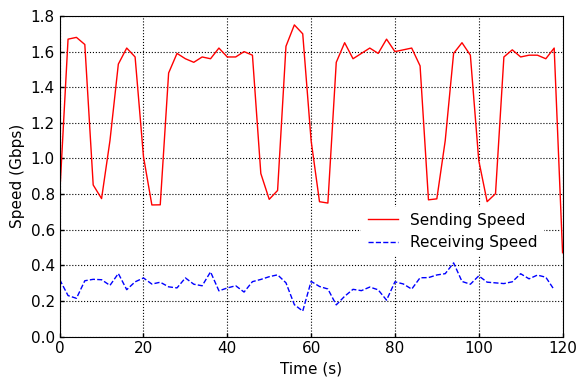

In [209]:
fastplot.plot([('Sending Speed', (send_speed_df['time'], send_speed_df['tx_speed'])),
              ('Receiving Speed', (recv_speed_df['time'], recv_speed_df['rx_speed']))],
                None,
                mode='line_multi',
                legend=True, legend_loc=[0.6, 0.25],
                figsize=(6, 4), grid=True,
                xlabel='Time (s)', 
                ylabel='Speed (Gbps)')